# AI 4 Materials Industry
# Case study 1: Faulty steel plates
# Notebook 1: Exploratory Data Analysis for tabular data


## The dataset

The dataset consists of a series of features describing 6 well-defined classes of defects and one class containing all other faults. The dataset was made available by the [Semeion research center](http://www.semeion.it/wordpress/)

The following urls provide a link to the dataset itself and some example code:
* [Dataset at UCI ML](http://archive.ics.uci.edu/ml/datasets/steel+plates+faults "Faulty steel plate dataset")
* [Kaggle page with example code](https://www.kaggle.com/uciml/faulty-steel-plates "Kaggle")

Type of dependent variables, which we will try to predict (7 Types of Steel Plates Faults):
1. Pastry
2. Z_Scratch
3. K_Scatch
4. Stains
5. Dirtiness
6. Bumps
7. Other_Faults


27 independent variables, which we will use to make predictions:
#### Position of the defect:
* X_Minimum: Positions of defects
* X_Maximum: ''
* Y_Minimum: ''
* Y_Maximum: '' 
* Edges_Index: mean(xmax,xmin)/length of conveyor -- "How far away are we from the edge of the conveyer"


#### Size of the defect:
* X_Perimeter: Bigger than xmax - xmin so likely a non-straight connect - see correlation with differences
* Y_Perimeter: Ditto total area / 1D size?
* Outside_X_Index: (X_Maximum - X_Minimum)/Length_of_Conveyer  (Relative size of fault compared to total conveyer)
* Edges_X_Index: (X_Maximum - X_Minimum) / X_Perimeter
* Edges_Y_Index: (Y_Maximum - Y_Minimum) / Y_Perimeter
* Log_X_Index: log of Outside_X_Index
* Log_Y_Index: log of (Y_Maximum - Y_Minimum), scaled with a factor of ~2.3
* Pixels_Areas: Area of the defect in pixels
* LogOfAreas: log of pixel_areas
* SigmoidOfAreas: sigmoid of pixel_areas


#### Orientation of the defect:
* Square_Index: Absolute value of the orientation index
* Orientation_Index:  +- Sigmoid of squareness
* Outside_Global_Index: Classification of orientation index: 0.5 is square, and 0 or 1 is x or y directed -- sgn(Orientation_Index)/2 + 0.5


#### Properties of the production process:
* Length_of_Conveyer: Total size of plate (in pixels) in the X direction.
* TypeOfSteel_A300: A300 steel - https://www.zamet.it/en/Austenitic-Steel-A300/p/52
* TypeOfSteel_A400: A400 steel - https://www.zamet.it/en/A400-series-Ferritic-Stainless-Steels/p/54
* Steel_Plate_Thickness


#### Luminosity/brightness of the defect:
* Sum_of_Luminosity: Luminosity summed over the pixel areas
* Minimum_of_Luminosity: Least-bright pixel value 
* Maximum_of_Luminosity: Brightest pixel value
* Empty_Index: +- log X_Size\*Y_Size/Pixel_Area
* Luminosity_Index: Sum of luminosity/pixel areas -- Average luminosity



## Exploratory Data Analysis (EDA)

The first step when doing machine learning is always to explore the data you're going to work with.

* What is the type of data?
* What does it represent?
* What are the limitations?
* Is the dataset balanced? Is each class roughly equally represented?
* Which features correlate with each other? Does this make sense?
* Which features correlate with which output class?

Knowing what the data can and cannot tell you is crucial to know what kind of models can be built on top of it, and what these models can be capable of.

### Preliminary: Setting up the environment

Basic functions like plotting and doing math. It's not important if not everything in this step makes sense to you right away.

In [1]:
# This is simply to install the packages we'll be using, this only needs to happen once.
# It might be necessary to restart the kernel after this step

# ! pip install seaborn
# ! pip install scikit-learn
# ! pip install shap
# ! pip install pyarrow
# ! pip install matplotlib

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np # Math functions
import pandas as pd # Pandas is used for handling databases, and will be used for reading and manipulating the data
import matplotlib.pyplot as plt # Plot functions
import seaborn as sns # More plot functions

sns.set_palette('colorblind') # Making the plots colorblind-friendly
sns.set_style('darkgrid') # More info at https://seaborn.pydata.org/tutorial/aesthetics.html

### Reading the data

First, we read the data from the file `faults.csv`. For this we use pandas (`pd`) and read it as a pandas dataframe. In this case all the columns we want to read have been explicitly named, this isn't always necessary, but it helps to know exactly what is being read and what the dataframe contains.

After the dataframe has been read, we use the `describe()` function to get a summary of what is contained and what sorts of values we can find in each column.

It is very important to check whether there isn't any identifying column present. For example, if you want to teach a model to rank materials based on a certain property, and you start from an ordered dataset that has the rank encoded as a feature, then the model will probably simply learn to identify the rank and ignore all the "real" information.

In [3]:
df = pd.read_csv('faults.csv',header=0,names=['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas',
       'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity',
       'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer',
       'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Steel_Plate_Thickness',
       'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index',
       'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas',
       'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index',
       'SigmoidOfAreas', 'Pastry', 'Z_Scratch', 'K_Scratch', 'Stains',
       'Dirtiness', 'Bumps', 'Other_Faults'])
df.describe()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scratch,Stains,Dirtiness,Bumps,Other_Faults
count,1941.000000,1941.000000,1.941000e+03,1.941000e+03,1941.000000,1941.000000,1941.000000,1.941000e+03,1941.000000,1941.000000,...,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000
mean,571.136012,617.964451,1.650685e+06,1.650739e+06,1893.878413,111.855229,82.965997,2.063121e+05,84.548686,130.193715,...,0.083288,-0.131305,0.585420,0.081401,0.097888,0.201443,0.037094,0.028336,0.207110,0.346728
std,520.690671,497.627410,1.774578e+06,1.774590e+06,5168.459560,301.209187,426.482879,5.122936e+05,32.134276,18.690992,...,0.500868,0.148767,0.339452,0.273521,0.297239,0.401181,0.189042,0.165973,0.405339,0.476051
min,0.000000,4.000000,6.712000e+03,6.724000e+03,2.000000,2.000000,1.000000,2.500000e+02,0.000000,37.000000,...,-0.991000,-0.998900,0.119000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,51.000000,192.000000,4.712530e+05,4.712810e+05,84.000000,15.000000,13.000000,9.522000e+03,63.000000,124.000000,...,-0.333300,-0.195000,0.248200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,435.000000,467.000000,1.204128e+06,1.204136e+06,174.000000,26.000000,25.000000,1.920200e+04,90.000000,127.000000,...,0.095200,-0.133000,0.506300,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1053.000000,1072.000000,2.183073e+06,2.183084e+06,822.000000,84.000000,83.000000,8.301100e+04,106.000000,140.000000,...,0.511600,-0.066600,0.999800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1705.000000,1713.000000,1.298766e+07,1.298769e+07,152655.000000,10449.000000,18152.000000,1.159141e+07,203.000000,253.000000,...,0.991700,0.642100,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


To get a sense for what the actual data looks like, we can use the `head()` function, which shows us the first 5 rows of the dataframe.

In [4]:
df.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scratch,Stains,Dirtiness,Bumps,Other_Faults
0,42,50,270900,270944,267,17,44,24220,76,108,...,0.8182,-0.2913,0.5822,1,0,0,0,0,0,0
1,645,651,2538079,2538108,108,10,30,11397,84,123,...,0.7931,-0.1756,0.2984,1,0,0,0,0,0,0
2,829,835,1553913,1553931,71,8,19,7972,99,125,...,0.6667,-0.1228,0.2150,1,0,0,0,0,0,0
3,853,860,369370,369415,176,13,45,18996,99,126,...,0.8444,-0.1568,0.5212,1,0,0,0,0,0,0
4,1289,1306,498078,498335,2409,60,260,246930,37,126,...,0.9338,-0.1992,1.0000,1,0,0,0,0,0,0


We are dealing with tabular data, data stored in a table with columns and rows.

A row is a specific data point and can be addressed with `.iloc` in much the same way as a Python list.

In [5]:
df.iloc[42]

X_Minimum                 1545.0000
X_Maximum                 1557.0000
Y_Minimum                19815.0000
Y_Maximum                19841.0000
Pixels_Areas               234.0000
X_Perimeter                 20.0000
Y_Perimeter                 26.0000
Sum_of_Luminosity        23207.0000
Minimum_of_Luminosity       66.0000
Maximum_of_Luminosity      124.0000
Length_of_Conveyer        1627.0000
TypeOfSteel_A300             0.0000
TypeOfSteel_A400             1.0000
Steel_Plate_Thickness       40.0000
Edges_Index                  0.0860
Empty_Index                  0.2500
Square_Index                 0.4615
Outside_X_Index              0.0074
Edges_X_Index                0.6000
Edges_Y_Index                1.0000
Outside_Global_Index         1.0000
LogOfAreas                   2.3692
Log_X_Index                  1.0792
Log_Y_Index                  1.4150
Orientation_Index            0.5385
Luminosity_Index            -0.2252
SigmoidOfAreas               0.5162
Pastry                      

In [6]:
df.iloc[20:25].T # The .T operator transposes a grid, exchanging rows and columns.

,20,21,22,23,24
X_Minimum,17.0000,43.0000,63.0000,82.0000,75.0000
X_Maximum,28.0000,52.0000,72.0000,92.0000,84.0000
Y_Minimum,42683.0000,86284.0000,115485.0000,149044.0000,184350.0000
Y_Maximum,42717.0000,86313.0000,115504.0000,149083.0000,184383.0000
Pixels_Areas,284.0000,153.0000,106.0000,264.0000,201.0000
X_Perimeter,18.0000,13.0000,10.0000,15.0000,17.0000
Y_Perimeter,34.0000,29.0000,19.0000,39.0000,35.0000
Sum_of_Luminosity,32604.0000,17753.0000,13829.0000,32175.0000,27349.0000
Minimum_of_Luminosity,87.0000,101.0000,107.0000,92.0000,123.0000
Maximum_of_Luminosity,141.0000,134.0000,150.0000,141.0000,148.0000


A column is what we call a __feature__. These are typically labeled with a name and can be called as such.

In [7]:
df["X_Maximum"]

0         50
1        651
2        835
3        860
4       1306
        ... 
1936     277
1937     175
1938     174
1939     170
1940    1281
Name: X_Maximum, Length: 1941, dtype: int64

We can select multiple columns at once by passing a list.

In [8]:
df[["X_Maximum", "X_Minimum"]] # Note the brackets!

,X_Maximum,X_Minimum
0,50,42
1,651,645
2,835,829
3,860,853
4,1306,1289
...,...,...
1936,277,249
1937,175,144
1938,174,145
1939,170,137


And perform arithmetic on them.

In [9]:
df["X_Maximum"] - df["X_Minimum"]

0        8
1        6
2        6
3        7
4       17
        ..
1936    28
1937    31
1938    29
1939    33
1940    20
Length: 1941, dtype: int64

We can even store this as a new feature. This statement creates a new feature column `X_Size` and stores the result of the operation inside.

In [10]:
df["X_Size"] = df["X_Maximum"] - df["X_Minimum"]

Here, it's also useful to consider what information is being encoded in these features. We are looking at faults on steel plates. The `X_minimum`, `X_maximum`, `Y_minimum` and `Y_maximum` tell us the boundaries of where the fault starts and ends. But it might be more useful to store the location and size, instead.

### Exercise 1:

Create three new features called `X_Center`, `Y_Center` and `Y_Size` which store the coordinates of the center of the defect and its size. Be aware that these feature names are case sensitive!

## Solution:

In [11]:
df["Y_Size"] = df["Y_Maximum"] - df["Y_Minimum"]
df["X_Center"] = 0.5*(df["X_Maximum"] + df["X_Minimum"])
df["Y_Center"] = 0.5*(df["Y_Maximum"] + df["Y_Minimum"])

We will use the `pandas.Dataframe.drop` command and remove the four original columns `X_minimum`, `X_maximum`, `Y_minimum` and `Y_maximum` from the dataframe, as we now have a more intuitive way of storing the same information.

In [12]:
df = df.drop(columns=["X_Minimum", "X_Maximum", "Y_Minimum", "Y_Maximum"])
# We could keep the original features, but if we want to be able to interpret our models,
# it helps to not have too many features that encode the same information.

Let's save the dataset for use in our other notebook. `pandas.DataFrame.to_csv` writes it to a standard CSV file, readable by Excel and other spreadsheet software. When reading the CSV again pandas will have to interpret how to store the data. The `pandas.Dataframe.to_Feather` method stores data in a binary format which does not require parsing and is thus much faster to read. If you want to add more features don't forget to do this before saving the file, then later you can read it again in the next notebook!

In [13]:
df.to_feather("vsc-ai4mi-case1-eda.feather")

***

## Plotting
Plots can be more easily interpreted than bare numbers, so it can be useful to plot an overview of certain things. For example, using a pie chart to see the distribution of classes, a histogram to see a distribution of values, or a scatterplot to see how two features might relate.

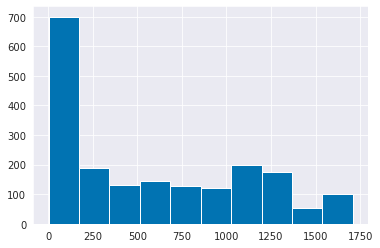

In [14]:
df['X_Center'].hist();

Let us see what a plot looks like between the orientation index and square index.

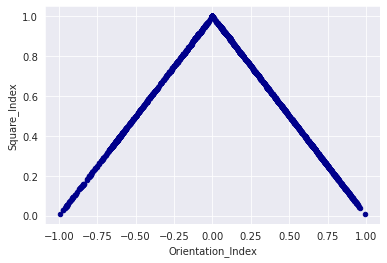

In [15]:
df.plot.scatter(x='Orientation_Index',y='Square_Index', color="darkblue");

In this case, it's clear that the Orientation Index encodes information about
how elongated the defect is, and whether its long side is in the X- or Y-direction.
The square index encodes whether the defect is strongly elongated (-1 or +1) or completely square (0).

Note that a linear regression between these features would show a correlation of 0.
This would imply they're not related at all, while it is in fact the perfect correlation in the
first half that perfectly cancels the anti-correlation in the second half.
This shows that it can help to not blindly rely on simplified statistics,
but that an actual look at the data can be useful.

### Correlation of features

It can be useful to see which features are correlated and which are not, especially later on when we investigate what features our model uses to make decisions, to see if similar information is stored across multiple features. There are two types of correlation that are useful here: Pearson correlation and Spearman correlation.

Pearson is a measure for whether two variables are linearly correlated, Spearman is a measure for whether if one variable goes up, if the other goes up as well. If you simply want a sense of whether two variables encode similar information or not, Spearman is a good choice.

Let us plot two features that we know will be correlated, the `Pixels_Areas` and `SigmoidOfAreas`, the latter being the sigmoid function of the former.

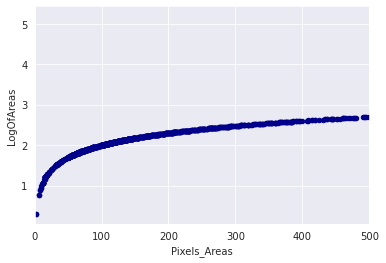

In [16]:
df.plot.scatter(x='Pixels_Areas',y='LogOfAreas', color="darkblue", xlim=[0,500]);

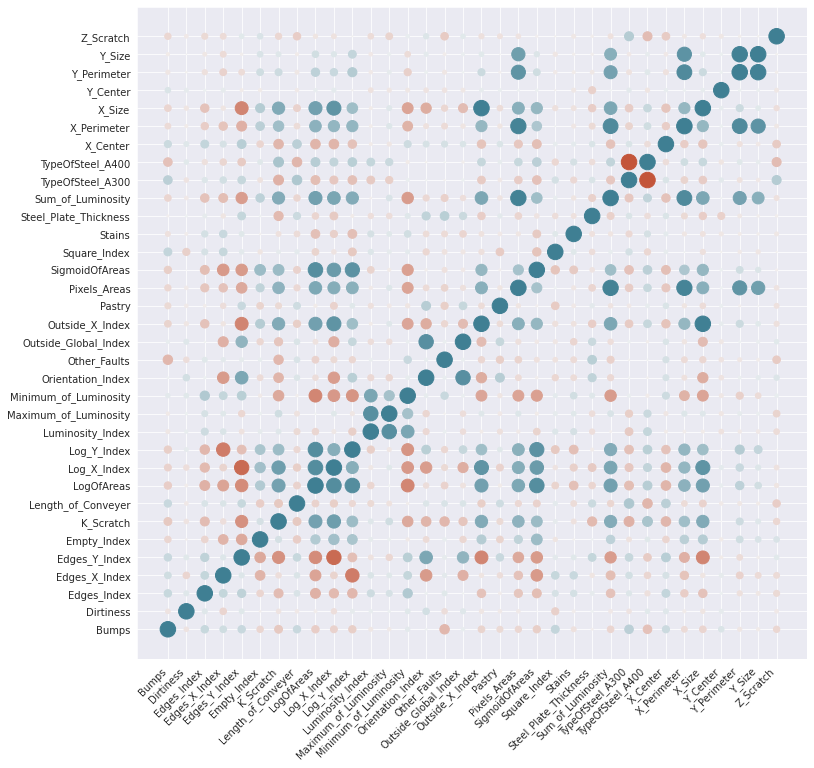

In [17]:
from functions import plot_correlation

plot_correlation(df, method="pearson")

## Exercise 2

* Which features (anti-)correlate? Are there redundant features?
* Can you explain some of these correlations?
* Choose a pair of correlated features and plot them. Do you notice a difference between Pearson and Spearman correlation?
* Which features correlate with the K_Scratch defect?

### One-Hot encoding

This dataset uses so-called one-hot encoding, meaning that each target class has a separate column. If the specific sample is of that class, the corresponding column will have a 1, and all other columns will be 0. The other possible encoding is to have one single column to determine the class of defect, represented by a number 0 to 6.

In [18]:
df[['Pastry', 'Z_Scratch', 'K_Scratch', 'Stains',
       'Dirtiness', 'Bumps', 'Other_Faults']].iloc[[5, 300, 500, 750, 850, 1200, 1800]]

,Pastry,Z_Scratch,K_Scratch,Stains,Dirtiness,Bumps,Other_Faults
5,1,0,0,0,0,0,0
300,0,1,0,0,0,0,0
500,0,0,1,0,0,0,0
750,0,0,0,1,0,0,0
850,0,0,0,0,1,0,0
1200,0,0,0,0,0,1,0
1800,0,0,0,0,0,0,1


In [19]:
# It's useful to have a combined Defect_Type feature
target = ['Pastry', 'Z_Scratch', 'K_Scratch', 'Stains',
       'Dirtiness', 'Bumps', 'Other_Faults']

df['Defect_Type'] = 0 # Create a new feature, fill it with 0
for t in target:
    df.loc[df[t] == 1, 'Defect_Type'] = target.index(t) # Change one-hot encoding to a combined class

Let's look at the distribution of these classes. First we'll take a count of how many of each class are in the dataset.

In [48]:
df['Defect_Type'].value_counts()

6    673
5    402
2    391
1    190
0    158
3     72
4     55
Name: Defect_Type, dtype: int64

For plotting purposes, it's useful to sort them not by value but by index, so that we can label them.

In [49]:
df['Defect_Type'].value_counts().sort_index()

0    158
1    190
2    391
3     72
4     55
5    402
6    673
Name: Defect_Type, dtype: int64

Let's store this in a varaible `cts` and plot it in a pie chart.

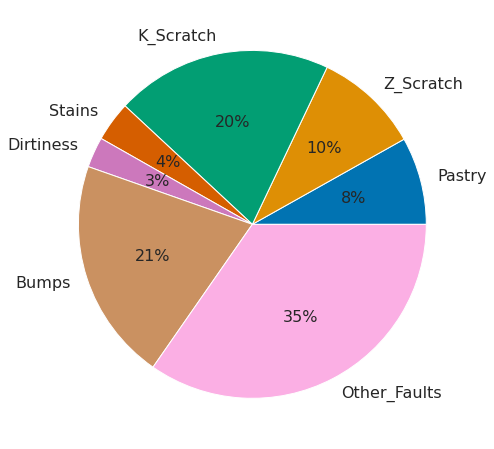

In [47]:
cts = df['Defect_Type'].value_counts().sort_index()

cts.plot.pie(labels=target, autopct='%1.0f%%', figsize=(8,8), fontsize=16, ylabel="");

## Exercise 3

* Which defect is most common?
* Which is least common?
* What do you think is the impact of the class distribution on how well a model will learn to recognize certain classes?

## Solution:

* Most common: Other_Faults
* Least common: Dirtiness
* Impact: model will have some success blindly predicting Other_Faults and never predicting Dirtiness

### Selecting parts of the dataframe

It's also possible to give logical statements as a selector to grab specific parts of the dataframe.

As an example, we can select all rows for which the type of steel is A300.

In [22]:
# This logical statement outputs a list of True and False values. 

df["TypeOfSteel_A300"] == 1

0        True
1        True
2        True
3       False
4       False
        ...  
1936    False
1937    False
1938    False
1939    False
1940     True
Name: TypeOfSteel_A300, Length: 1941, dtype: bool

In [23]:
# Putting this in the dataframe itself yields a selection.

df[ df["TypeOfSteel_A300"] == 1 ]

,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,...,K_Scratch,Stains,Dirtiness,Bumps,Other_Faults,X_Size,Y_Size,X_Center,Y_Center,Defect_Type
0,267,17,44,24220,76,108,1687,1,0,80,...,0,0,0,0,0,8,44,46.0,270922.0,0
1,108,10,30,11397,84,123,1687,1,0,80,...,0,0,0,0,0,6,29,648.0,2538093.5,0
2,71,8,19,7972,99,125,1623,1,0,100,...,0,0,0,0,0,6,18,832.0,1553922.0,0
44,98,16,21,10784,96,132,1690,1,0,60,...,0,0,0,0,0,8,21,454.0,1009988.5,0
45,267,43,49,22785,67,110,1690,1,0,60,...,0,0,0,0,0,9,49,1629.5,1702466.5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1901,67,29,12,8140,102,141,1692,1,0,143,...,0,0,0,0,1,16,9,840.0,712441.5,6
1902,76,22,10,9934,109,148,1692,1,0,143,...,0,0,0,0,1,21,7,1037.5,787018.5,6
1903,73,28,14,9247,111,143,1692,1,0,143,...,0,0,0,0,1,25,5,1287.5,883637.5,6
1904,102,42,22,12942,114,141,1694,1,0,143,...,0,0,0,0,1,22,17,994.0,895633.5,6


We can also combine the logical row selection with a selection of feature columns, for example, to get an overview of the position of defects on A300 steel.

In [24]:
df[df["TypeOfSteel_A300"] == 1][["X_Center", "Y_Center"]].describe()

,X_Center,Y_Center
count,777.000000,7.770000e+02
mean,674.628057,1.813912e+06
std,534.792622,1.453373e+06
min,2.000000,1.519000e+04
25%,145.000000,7.992960e+05
50%,617.500000,1.446812e+06
75%,1108.500000,2.519950e+06
max,1686.500000,1.143041e+07


## Exercise 4

* What can you say about the types of steel in the dataset?
* Take a look at the properties of A400 steel as well.
* Plot a piechart of the counts of defect types in A300 and A400 steel. How do they differ? 

https://www.zamet.it/en/Austenitic-Steel-A300/p/52

https://www.zamet.it/en/A400-series-Ferritic-Stainless-Steels/p/54

## Solution:

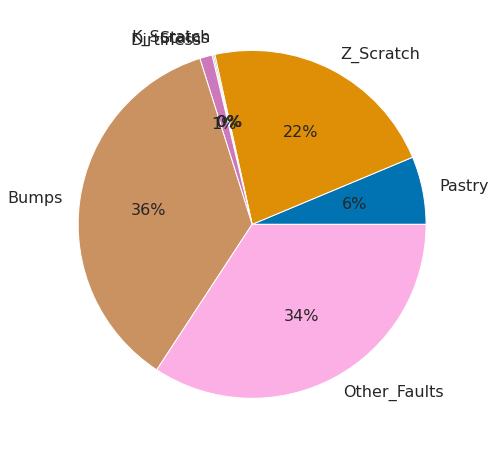

In [46]:
cts = df[df["TypeOfSteel_A300"] == 1]['Defect_Type'].value_counts().sort_index()

cts.plot.pie(labels=target, autopct='%1.0f%%', figsize=(8,8), fontsize=16, ylabel="");

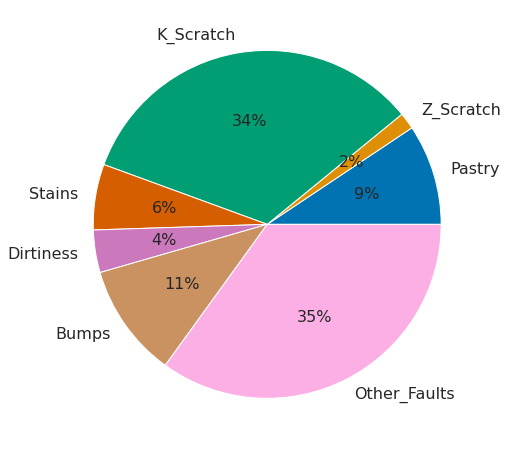

In [44]:
cts = df[df["TypeOfSteel_A400"] == 1]['Defect_Type'].value_counts().sort_index()

cts.plot.pie(labels=target, autopct='%1.0f%%', figsize=(8,8), fontsize=16, ylabel="");

## Exercise 5 (optional)

* Do all defects have the same size and shape? Plot histograms of the `X_Size` of a few different defects.
* Which are typically the largest?
* Which are typically the smallest?

## Solution:

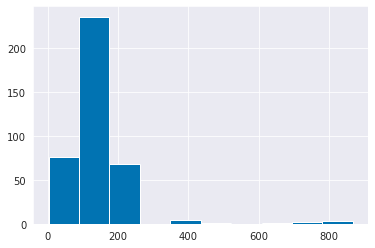

In [52]:
df[df["K_Scratch"] == 1]['X_Size'].hist();

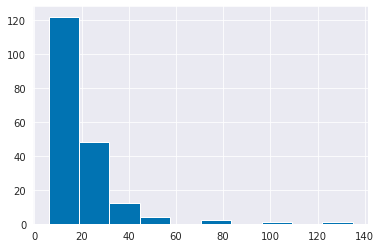

In [53]:
df[df["Z_Scratch"] == 1]['X_Size'].hist();

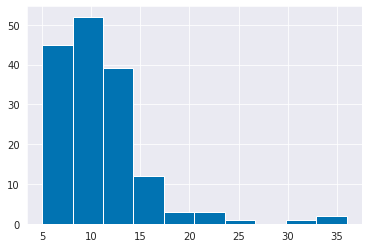

In [54]:
df[df["Pastry"] == 1]['X_Size'].hist();